# Use shapefiles to obtain regional data

Often we want to summarise gridded data over geographical regions like countries or states. These regions are typically not nice lat/lon rectangles. They are often represented by polygons in shapefile format.

We can use the `geopandas` and `regionmask` packages to create masks of these polygons on the gridded data.

Regionmask docs are good: https://regionmask.readthedocs.io/en/stable/

In [4]:
import xarray as xr
import regionmask

The first thing we need is the lat and lon coordinates from the grid we want to create a mask for.

An easy way to do this for ERA5 is to load a template file:

In [25]:
# Random temperature file
temp = xr.open_dataset(
    "/g/data/rt52/era5/single-levels/monthly-averaged/2t/2010/2t_era5_moda_sfc_20100101-20100131.nc"
)

In [26]:
lats = temp["latitude"]
lons = temp["longitude"]

Now, we need the regions. Some popular regions are already available in `regionmask`, including countries, US states, SREX regions... You can check the docs.

It's easier for us if `regionmask` has them. Let's say we're interested in getting the US states.

Also see: https://regionmask.readthedocs.io/en/stable/defined_countries.html

In [5]:
states = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50

In [9]:
states

<regionmask.Regions>
Name:     Natural Earth: US States 50m
Source:   http://www.naturalearthdata.com
overlap:  False

Regions:
 0 AK        Alaska
 1 AL       Alabama
 2 AR      Arkansas
 3 AZ       Arizona
 4 CA    California
.. ..           ...
46 VT       Vermont
47 WA    Washington
48 WI     Wisconsin
49 WV West Virginia
50 WY       Wyoming

[51 regions]

<GeoAxesSubplot: >

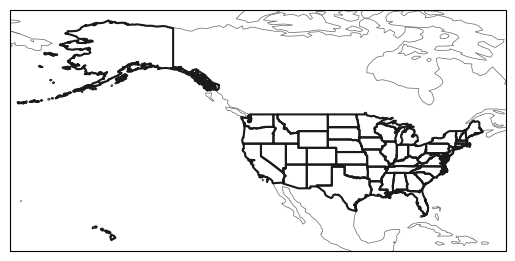

In [8]:
states.plot(add_label=False)

We can create a mask in one line:

In [13]:
mask = states.mask_3D(lons, lats)

This has added a 3rd dimension to our array: region, which is numbered, and has coordinates indicating the state name and the state abbreviation.

In [15]:
mask.dims

('region', 'latitude', 'longitude')

In [16]:
mask.region

<xarray.DataArray 'region' (region: 50)>
array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])
Coordinates:
  * region   (region) int64 0 1 2 3 4 5 6 8 9 10 ... 42 43 44 45 46 47 48 49 50
    abbrevs  (region) <U2 'AK' 'AL' 'AR' 'AZ' 'CA' ... 'VT' 'WA' 'WI' 'WV' 'WY'
    names    (region) <U14 'Alaska' 'Alabama' ... 'West Virginia' 'Wyoming'

For each region, we have a boolean mask

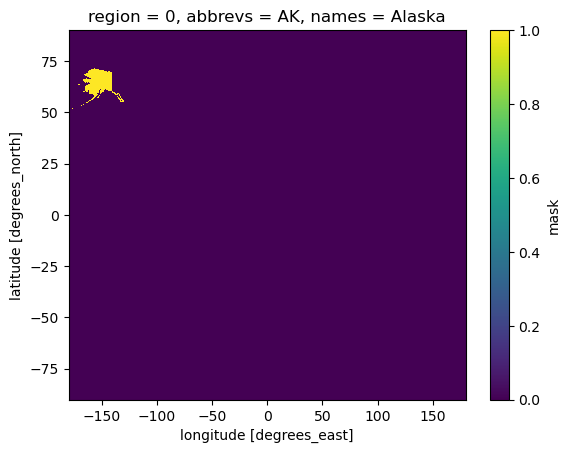

In [17]:
mask.sel(region=0).plot()

You might prefer to have the names or abbreviations as the dimension. Then we don't need to know the number of the region to select it.

In [21]:
mask_2 = mask.swap_dims({"region": "abbrevs"})

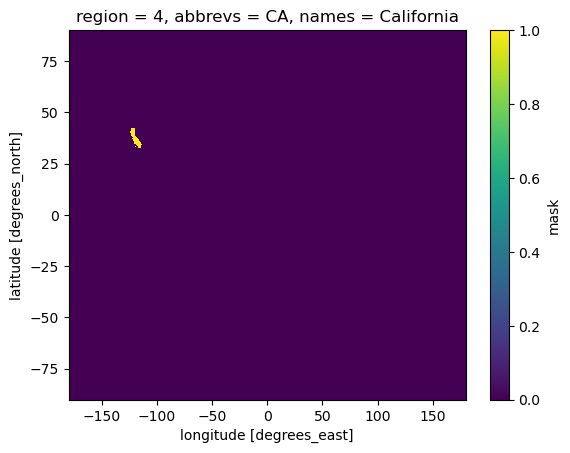

In [24]:
# California
mask_2.sel(abbrevs="CA").plot()

We can now use this mask to create regional averages. Let's do this for California.

First use the mask to mask out areas we don't want:

In [32]:
CA_temp = temp.where(mask_2.sel(abbrevs="CA"))

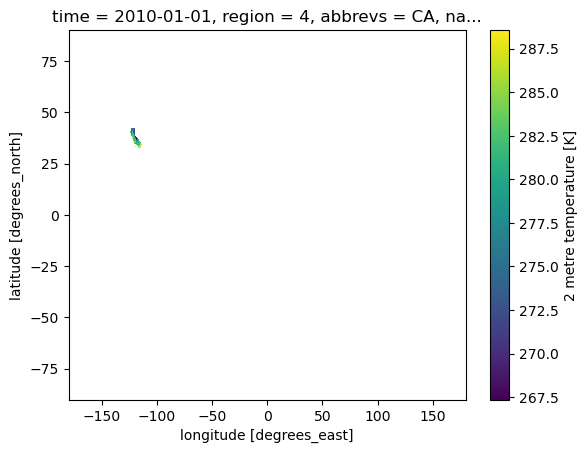

In [33]:
CA_temp.t2m.plot()

Now take the spatial mean

In [34]:
CA_temp.mean(["latitude", "longitude"])

<xarray.Dataset>
Dimensions:  (time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01
    region   int64 4
    abbrevs  <U2 'CA'
    names    <U14 'California'
Data variables:
    t2m      (time) float32 280.1

We can do this for multiple states at the same time:

In [37]:
mask_3 = mask_2.sel(abbrevs=["CA", "AK", "NY", "TX"])

In [45]:
temp.where(mask_3).mean(["latitude", "longitude"])

<xarray.Dataset>
Dimensions:  (time: 1, abbrevs: 4)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01
    region   (abbrevs) int64 4 0 34 43
  * abbrevs  (abbrevs) <U2 'CA' 'AK' 'NY' 'TX'
    names    (abbrevs) <U14 'California' 'Alaska' 'New York' 'Texas'
Data variables:
    t2m      (time, abbrevs) float32 280.1 252.6 267.9 280.1

### If the regions aren't in `regionmask`

You will need shapefiles from somewhere else. For example, I found the shapefiles for Australian states and territories from the Australian Bureau of Statistics website: https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files

We need the `geopandas` package to handle shapefiles.

In [46]:
import geopandas

Read in the states shapefile from my directory

In [47]:
state_gpd = geopandas.read_file(
    "/g/data/w42/dr6273/work/data/ABS/STE_2021_AUST_SHP_GDA2020/STE_2021_AUST_GDA2020.shp"
)

In [48]:
state_gpd.head()

,STE_CODE21,STE_NAME21,CHG_FLAG21,CHG_LBL21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry
0,1,New South Wales,0,No change,AUS,Australia,8.007977e+05,http://linked.data.gov.au/dataset/asgsed3/STE/1,"MULTIPOLYGON (((159.06230 -31.50886, 159.06218..."
1,2,Victoria,0,No change,AUS,Australia,2.274962e+05,http://linked.data.gov.au/dataset/asgsed3/STE/2,"MULTIPOLYGON (((146.29286 -39.15778, 146.29341..."
2,3,Queensland,0,No change,AUS,Australia,1.730171e+06,http://linked.data.gov.au/dataset/asgsed3/STE/3,"MULTIPOLYGON (((142.53140 -10.68301, 142.53072..."
3,4,South Australia,0,No change,AUS,Australia,9.842314e+05,http://linked.data.gov.au/dataset/asgsed3/STE/4,"MULTIPOLYGON (((140.66025 -38.06256, 140.66006..."
4,5,Western Australia,0,No change,AUS,Australia,2.526632e+06,http://linked.data.gov.au/dataset/asgsed3/STE/5,"MULTIPOLYGON (((117.86953 -35.19108, 117.86961..."


It is the geometry column that contains our region information. Now we use `regionmask` to create the mask

In [49]:
mask = regionmask.mask_3D_geopandas(
    state_gpd,
    lons,
    lats
)

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/rasterio/features.py:324: ShapeSkipWarning: Invalid or empty shape None at index 9 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)


In [50]:
mask

<xarray.DataArray 'mask' (region: 8, latitude: 721, longitude: 1440)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * region     (region) int64 0 1 2 3 4 5 6 7

Plot for the first region (NSW)

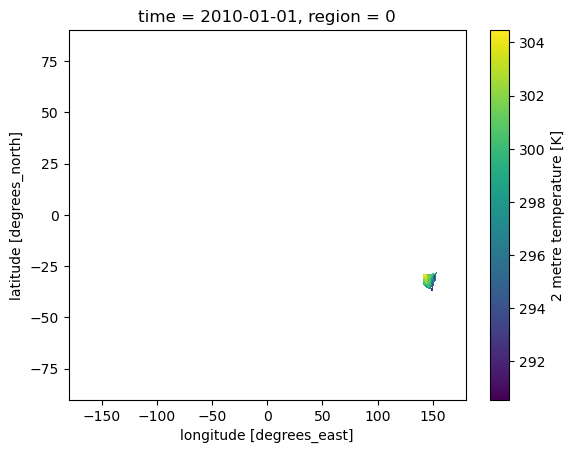

In [54]:
temp.where(mask.sel(region=0)).t2m.plot()